In [1]:
!pip3 install albumentations

In [2]:
!pip3 install segmentation-models-pytorch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os

from tqdm.notebook import tqdm
from torchsummary import summary
import segmentation_models_pytorch as smp

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda')

In [6]:
IMAGE_PATH = "/home/enfycius/Documents/LH_Dataset/Semantic_Segmentation/imgs_v2/"
MASK_PATH = "/home/enfycius/Documents/LH_Dataset/Semantic_Segmentation/labels_v2/"

In [7]:
n_classes = 1

def create_df():
    name = []

    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [8]:
df = create_df()

print('Total Images: ', len(df))

Total Images:  71


In [9]:
X_train_val, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_train_val, test_size=0.15, random_state=19)

In [10]:
print('Train Size:', len(X_train))
print('Val Size:', len(X_val))
print('Test Size:', len(X_test))

Train Size: 53
Val Size: 10
Test Size: 8


In [11]:
img = Image.open(IMAGE_PATH + df['id'][10] + '.png')
mask = Image.open(MASK_PATH + df['id'][10] + '.png')

In [12]:
df['id'][10]

'0132'

In [13]:
print('Image Size:', np.asarray(img).shape)
print('Mask Size:', np.asarray(mask).shape)

Image Size: (1242, 2208, 4)
Mask Size: (1242, 2208)


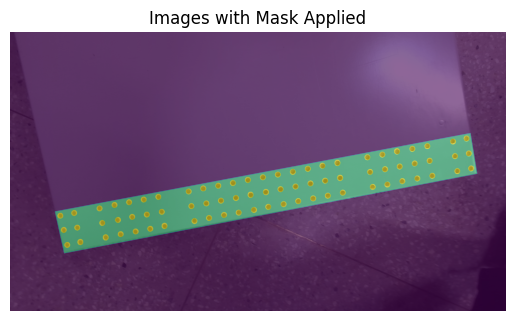

In [14]:
plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Images with Mask Applied')
plt.axis('off')
plt.show()

In [15]:
class BoltDataset(Dataset):
    def __init__(self, img_path, label_path, X, mean, std, transform = None, patch = False):
        self.img_path = img_path
        self.label_path = label_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        mask = cv2.imread(self.label_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image = img, mask = mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask
    
def tiles(self, img, mask):
    img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
    img_patches = img_patches.contiguous().view(3, -1, 512, 768)
    img_patches = img_patches.permute(1, 0, 2, 3)

    mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
    mask_patches = mask_patches.contiguous().view(-1, 512, 768)

    return img_patches, mask_patches

In [16]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), \
                     A.VerticalFlip(), A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0, 0.5), (0, 0.5)), \
                        A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), \
                   A.GridDistortion(p=0.2)])

train_set = BoltDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = BoltDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

batch_size = 5

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [17]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [18]:
def get_model():
    NUM_CLASSES = 4

    model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=NUM_CLASSES,\
                      activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

    return model

In [19]:
model = get_model()

In [20]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [21]:
for param in model.parameters():
    param.requires_grad = True


In [22]:
model.train()

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [23]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())

    return accuracy


In [24]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=1):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []

        for cls in range(0, n_classes):
            true_class = pred_mask == cls
            true_label = mask == cls

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)

        return np.nanmean(iou_per_class)
    

In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [26]:
MODEL_SAVE_PATH = "/home/enfycius/Documents/LH_Dataset/Semantic_Segmentation/models_v2/"

In [27]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    
    train_losses = []
    test_losses = []

    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf

    decrease = 1; not_improve = 0

    fit_time = time.time()

    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        model.train()

        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data

            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles  = mask_tiles.view(-1, h, 2)

            image = image_tiles.to(device); mask = mask_tiles.to(device)

            output = model(image)
            loss = criterion(output, mask)

            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0

            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device)
                    output = model(image)

                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)

                    loss = criterion(output, mask)
                    test_loss += loss.item()

            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))


            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, MODEL_SAVE_PATH + 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                
                print(f'Loss Not Decrease for {not_improve} time')

                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))

            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))

    return history


In [28]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.602 
Epoch:1/30.. Train Loss: 1.642.. Val Loss: 1.602.. Train mIoU:0.116.. Val mIoU: 0.098.. Train Acc:0.152.. Val Acc:0.170.. Time: 0.14m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.602 >> 1.517 
Epoch:2/30.. Train Loss: 1.338.. Val Loss: 1.517.. Train mIoU:0.239.. Val mIoU: 0.346.. Train Acc:0.300.. Val Acc:0.414.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.517 >> 1.217 
Epoch:3/30.. Train Loss: 1.056.. Val Loss: 1.217.. Train mIoU:0.543.. Val mIoU: 0.725.. Train Acc:0.585.. Val Acc:0.748.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.217 >> 0.661 
saving model...
Epoch:4/30.. Train Loss: 0.796.. Val Loss: 0.661.. Train mIoU:0.853.. Val mIoU: 0.922.. Train Acc:0.859.. Val Acc:0.920.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.661 >> 0.338 
Epoch:5/30.. Train Loss: 0.557.. Val Loss: 0.338.. Train mIoU:0.963.. Val mIoU: 0.975.. Train Acc:0.956.. Val Acc:0.970.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.338 >> 0.208 
Epoch:6/30.. Train Loss: 0.359.. Val Loss: 0.208.. Train mIoU:0.985.. Val mIoU: 0.991.. Train Acc:0.982.. Val Acc:0.989.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.208 >> 0.160 
Epoch:7/30.. Train Loss: 0.220.. Val Loss: 0.160.. Train mIoU:0.991.. Val mIoU: 0.992.. Train Acc:0.989.. Val Acc:0.991.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.160 >> 0.115 
Epoch:8/30.. Train Loss: 0.139.. Val Loss: 0.115.. Train mIoU:0.992.. Val mIoU: 0.992.. Train Acc:0.990.. Val Acc:0.991.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.115 >> 0.085 
saving model...
Epoch:9/30.. Train Loss: 0.100.. Val Loss: 0.085.. Train mIoU:0.992.. Val mIoU: 0.993.. Train Acc:0.990.. Val Acc:0.992.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.085 >> 0.066 
Epoch:10/30.. Train Loss: 0.074.. Val Loss: 0.066.. Train mIoU:0.993.. Val mIoU: 0.994.. Train Acc:0.992.. Val Acc:0.993.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.066 >> 0.053 
Epoch:11/30.. Train Loss: 0.061.. Val Loss: 0.053.. Train mIoU:0.994.. Val mIoU: 0.995.. Train Acc:0.992.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.053 >> 0.044 
Epoch:12/30.. Train Loss: 0.053.. Val Loss: 0.044.. Train mIoU:0.994.. Val mIoU: 0.995.. Train Acc:0.992.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.044 >> 0.044 
Epoch:13/30.. Train Loss: 0.046.. Val Loss: 0.044.. Train mIoU:0.994.. Val mIoU: 0.994.. Train Acc:0.993.. Val Acc:0.992.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.044 >> 0.038 
saving model...
Epoch:14/30.. Train Loss: 0.044.. Val Loss: 0.038.. Train mIoU:0.993.. Val mIoU: 0.995.. Train Acc:0.992.. Val Acc:0.993.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.038 >> 0.034 
Epoch:15/30.. Train Loss: 0.038.. Val Loss: 0.034.. Train mIoU:0.994.. Val mIoU: 0.996.. Train Acc:0.993.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.034 >> 0.031 
Epoch:16/30.. Train Loss: 0.036.. Val Loss: 0.031.. Train mIoU:0.995.. Val mIoU: 0.996.. Train Acc:0.993.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.031 >> 0.029 
Epoch:17/30.. Train Loss: 0.033.. Val Loss: 0.029.. Train mIoU:0.994.. Val mIoU: 0.996.. Train Acc:0.993.. Val Acc:0.995.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.029 >> 0.029 
Epoch:18/30.. Train Loss: 0.033.. Val Loss: 0.029.. Train mIoU:0.994.. Val mIoU: 0.996.. Train Acc:0.993.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.029 >> 0.028 
saving model...
Epoch:19/30.. Train Loss: 0.031.. Val Loss: 0.028.. Train mIoU:0.994.. Val mIoU: 0.995.. Train Acc:0.993.. Val Acc:0.994.. Time: 0.13m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.028 >> 0.027 
Epoch:20/30.. Train Loss: 0.031.. Val Loss: 0.027.. Train mIoU:0.994.. Val mIoU: 0.995.. Train Acc:0.993.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.027 >> 0.026 
Epoch:21/30.. Train Loss: 0.028.. Val Loss: 0.026.. Train mIoU:0.995.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.026 >> 0.026 
Epoch:22/30.. Train Loss: 0.027.. Val Loss: 0.026.. Train mIoU:0.995.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.026 >> 0.025 
Epoch:23/30.. Train Loss: 0.026.. Val Loss: 0.025.. Train mIoU:0.996.. Val mIoU: 0.995.. Train Acc:0.994.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.025 >> 0.024 
saving model...
Epoch:24/30.. Train Loss: 0.026.. Val Loss: 0.024.. Train mIoU:0.996.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.995.. Time: 0.13m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:25/30.. Train Loss: 0.025.. Val Loss: 0.026.. Train mIoU:0.996.. Val mIoU: 0.995.. Train Acc:0.994.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.026 >> 0.023 
Epoch:26/30.. Train Loss: 0.025.. Val Loss: 0.023.. Train mIoU:0.996.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.995.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:27/30.. Train Loss: 0.025.. Val Loss: 0.025.. Train mIoU:0.996.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.994.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.025 >> 0.023 
Epoch:28/30.. Train Loss: 0.024.. Val Loss: 0.023.. Train mIoU:0.996.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.995.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:29/30.. Train Loss: 0.025.. Val Loss: 0.024.. Train mIoU:0.996.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.995.. Time: 0.12m


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:30/30.. Train Loss: 0.025.. Val Loss: 0.024.. Train mIoU:0.996.. Val mIoU: 0.996.. Train Acc:0.994.. Val Acc:0.994.. Time: 0.12m
Total time: 3.65 m


In [29]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [30]:
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU', marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [31]:
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy', marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

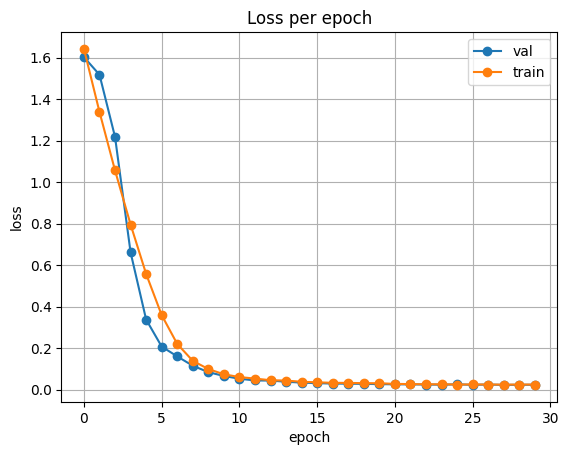

In [32]:
plot_loss(history)

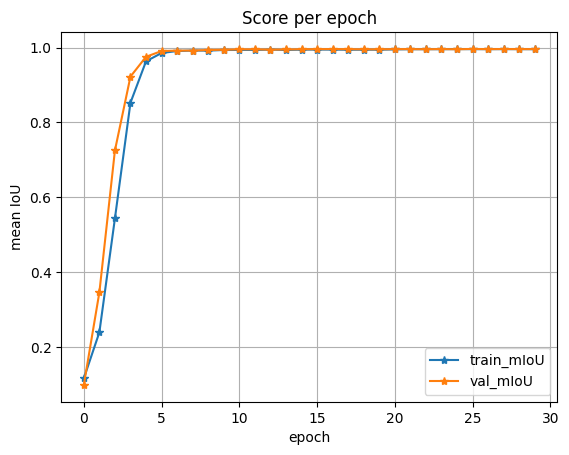

In [33]:
plot_score(history)

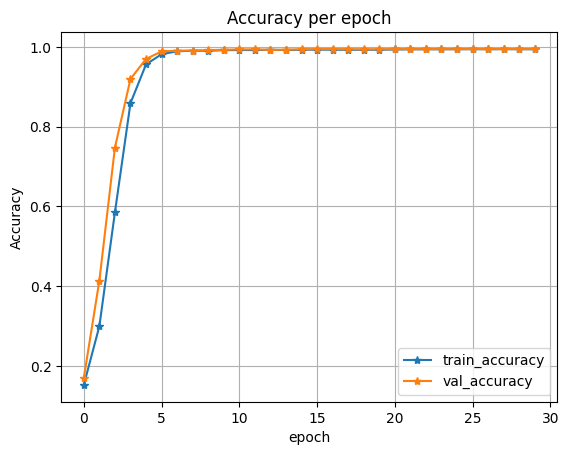

In [34]:
plot_acc(history)

In [35]:
class BoltTestDataset(Dataset):
    def __init__(self, img_path, label_path, X, transform=None):
        self.img_path = img_path
        self.label_path = label_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.label_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask

In [36]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = BoltTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [37]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    
    model.to(device); image=image.to(device)
    
    mask = mask.to(device)
    
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)

    return masked, score

In [38]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()

    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)

    model.to(device); image=image.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)

        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
        
    return masked, acc

In [39]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [40]:
def miou_score(model, test_set):
    score_iou = []
    
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)

    return score_iou

In [41]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/8 [00:00<?, ?it/s]

In [42]:
def pixel_acc(model, test_set):
    accuracy = []
    
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)

    return accuracy

In [43]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/8 [00:00<?, ?it/s]

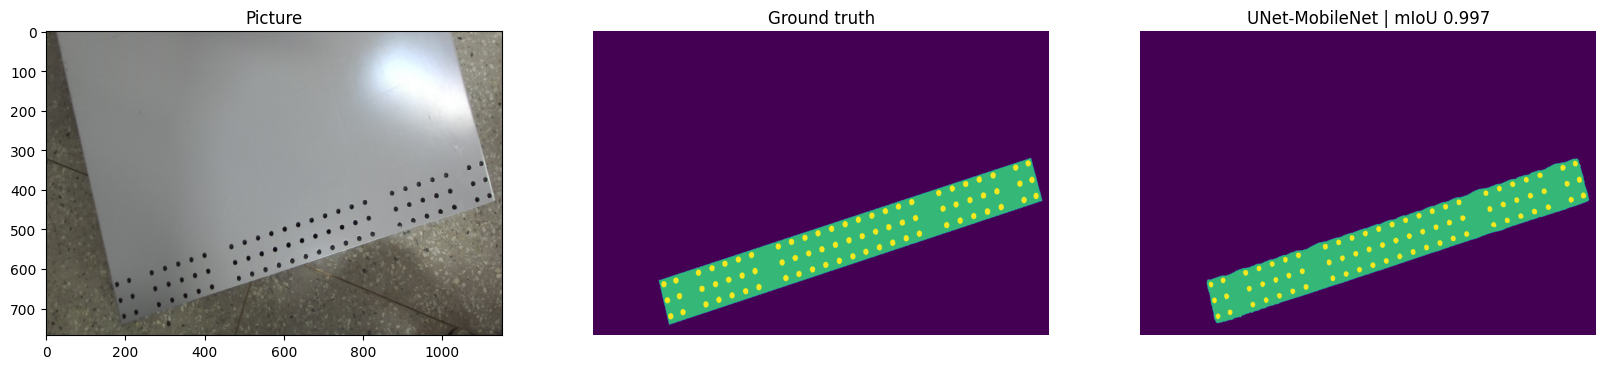

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [45]:
import matplotlib.pyplot as plt

In [46]:
def path_to_img(paths, flag=cv2.IMREAD_COLOR):
    imgs = []

    for path in paths:
        imgs.append(cv2.imread(path, flag))
        
    return imgs

In [47]:
def plot_imgs_labels(imgs, masks, paths = None, n_row = 10, n_col = 10, figsize = (12, 12), bottom = 0.1, \
                right = 0.8, top = 0.9):
    
    _, axs = plt.subplots(n_row, n_col, figsize=figsize)
    axs = axs.flatten()

    if paths is not None:
        for img, masks, path, ax in zip(imgs, masks, paths, axs):
            ax.title.set_text(os.path.split(path)[1])

            ax.imshow(img)
            ax.imshow(masks, alpha=0.6)

    else:
        for img, masks, ax in zip(imgs, masks, axs):
            ax.imshow(img)
            ax.imshow(masks, alpha=0.6)

    plt.subplots_adjust(bottom = bottom, right = right, top = top)
    plt.show()

In [48]:
test_imgs = []
test_masks = []

for test_img, test_mask in test_set:
    test_imgs.append(test_img)
    test_masks.append(test_mask)

In [49]:
len(test_imgs)

8

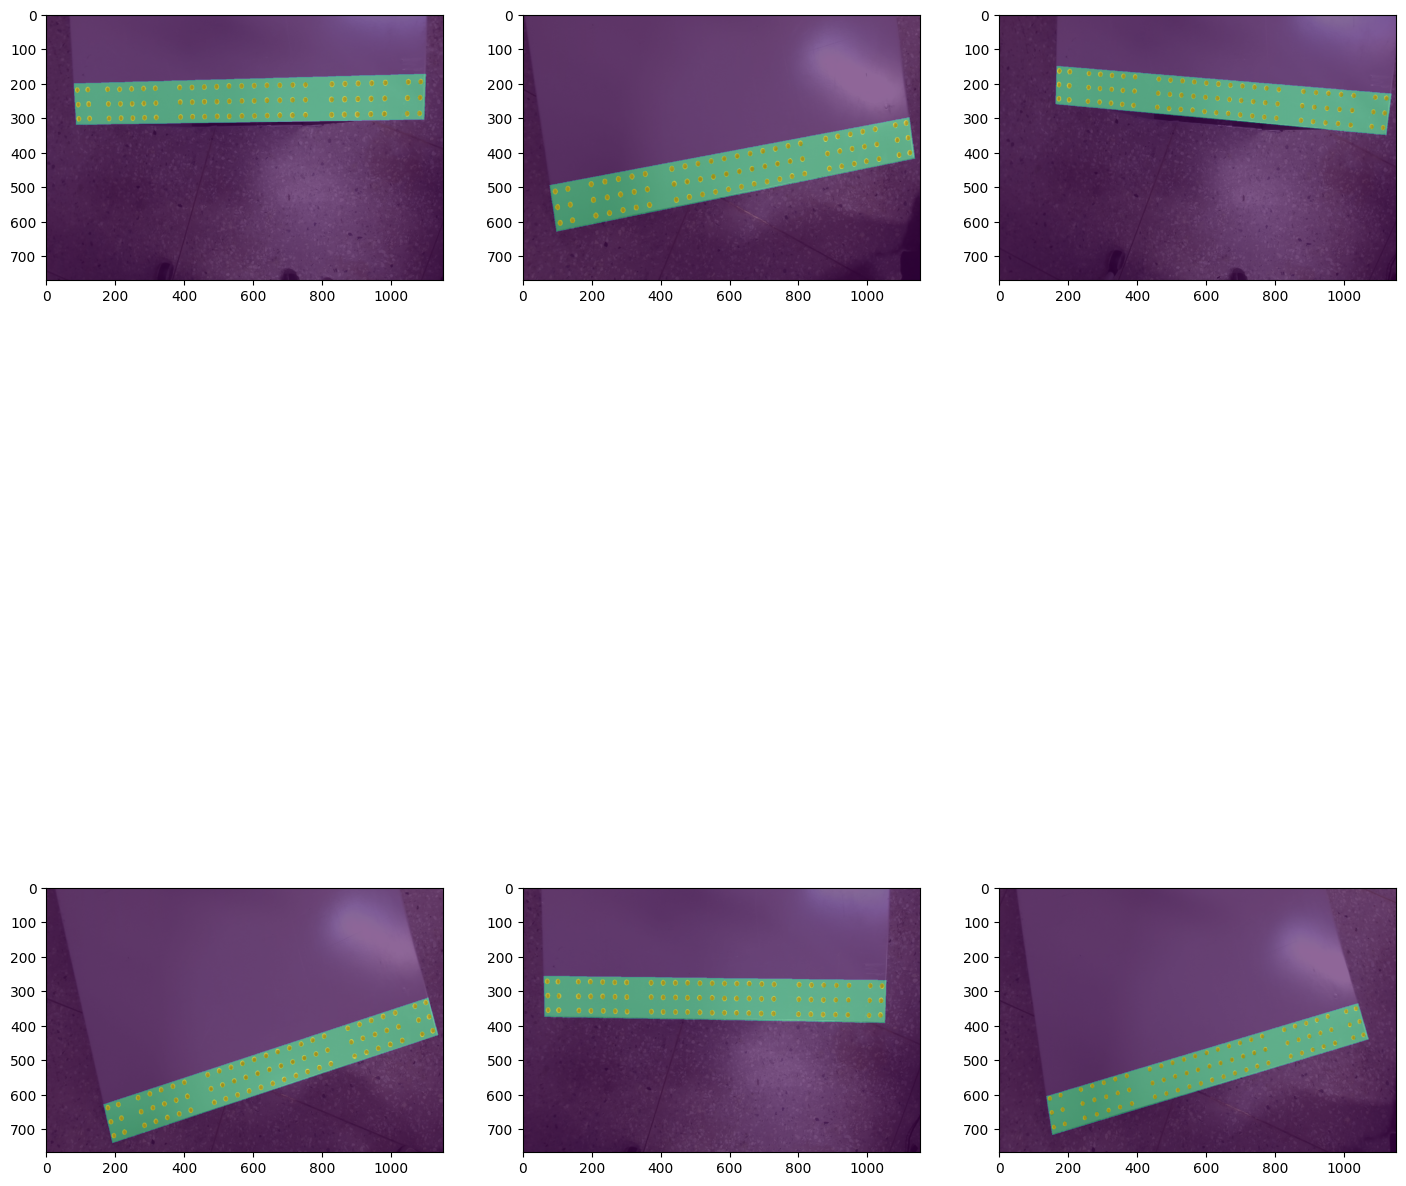

In [50]:
plot_imgs_labels(imgs = test_imgs, \
                 masks = test_masks, \
            n_row = len(test_imgs) // 3, \
            n_col = 3, \
            figsize = (20, 20))

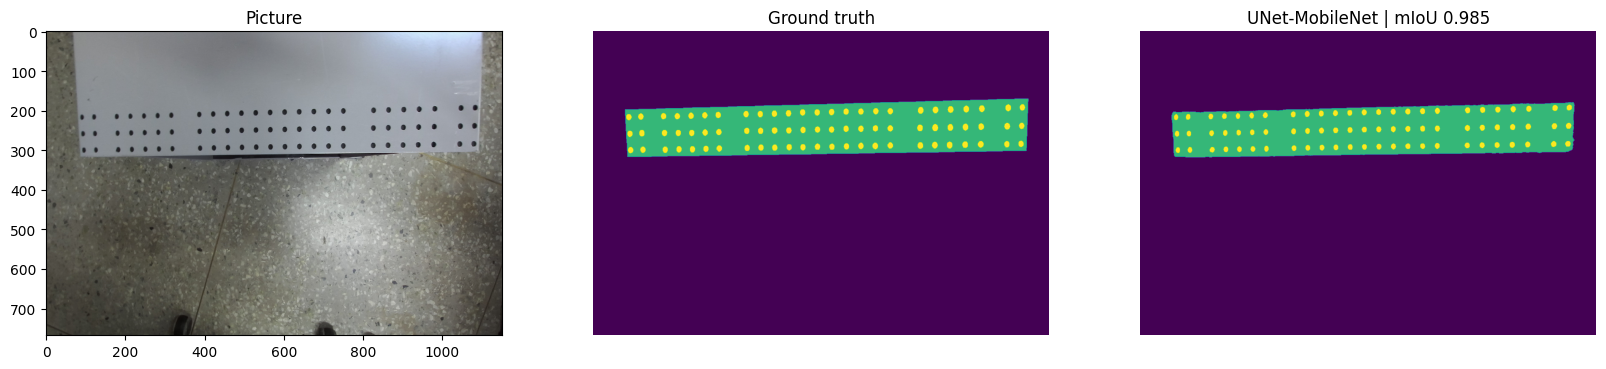

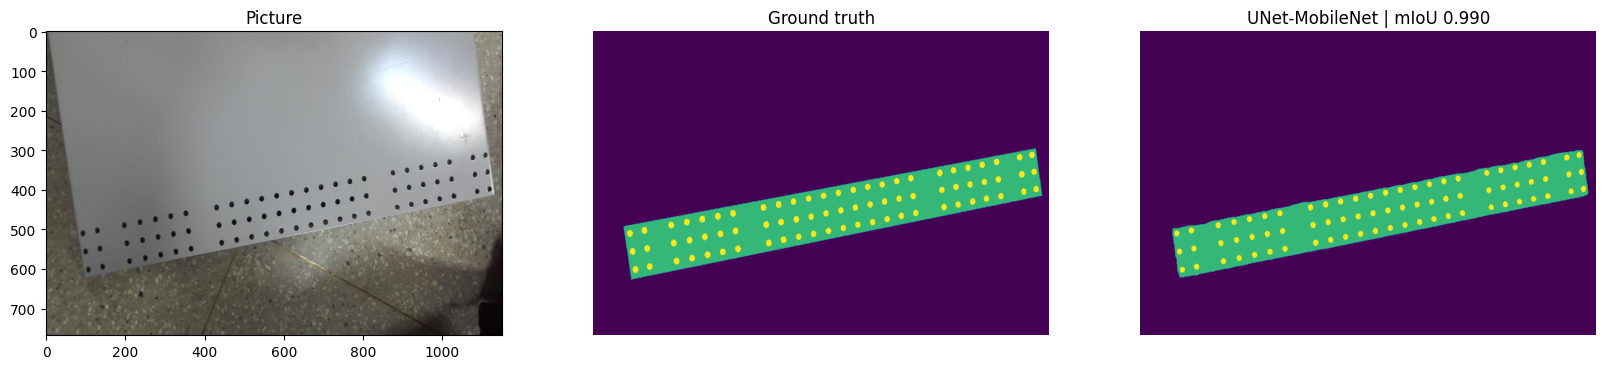

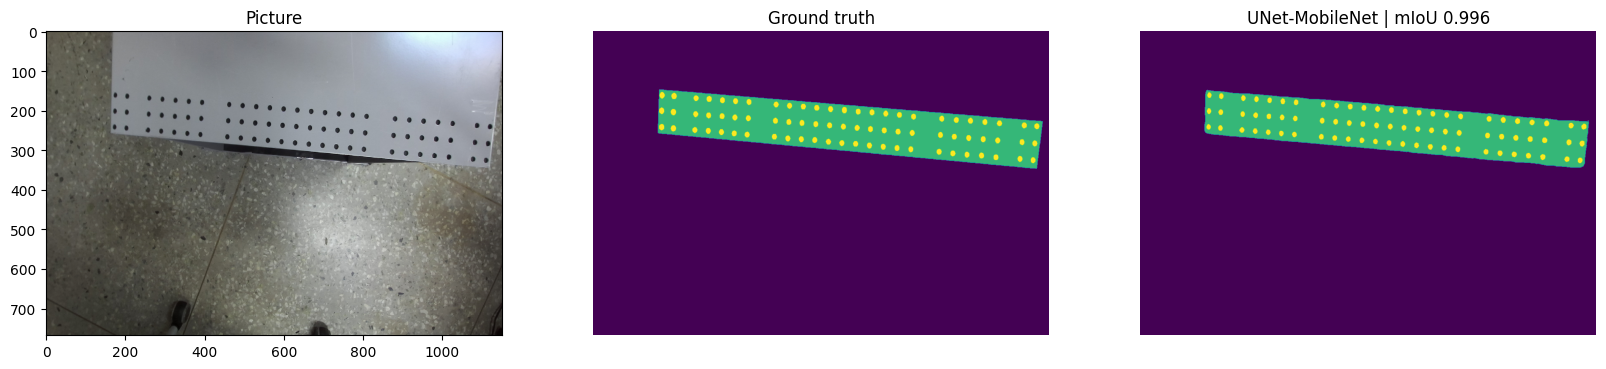

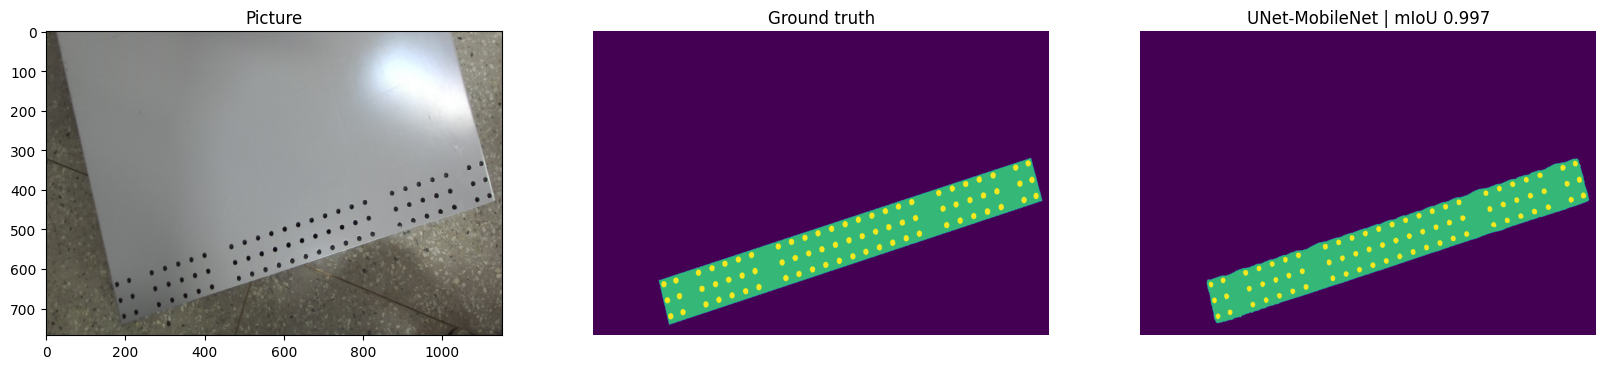

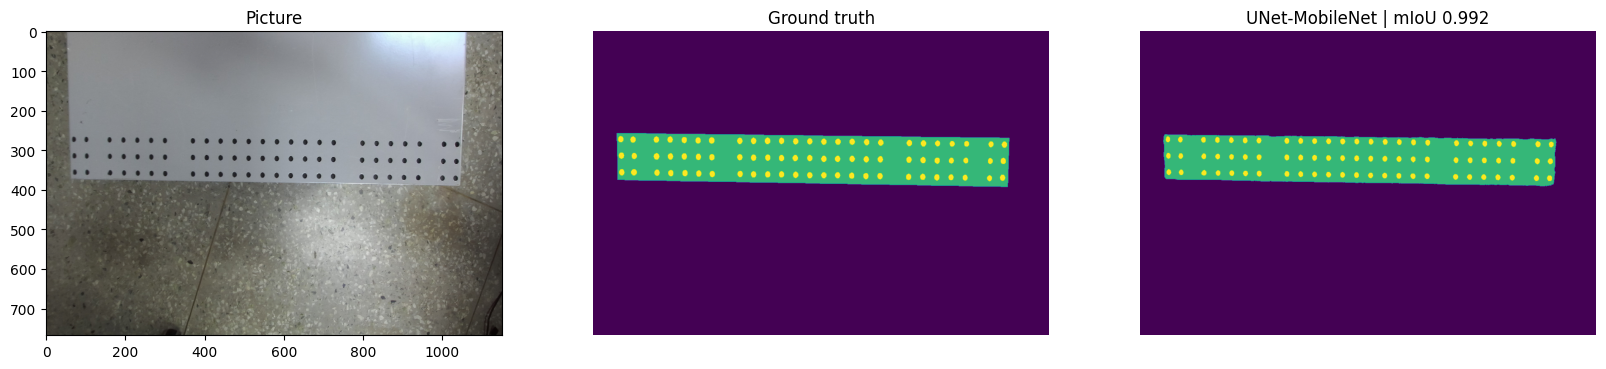

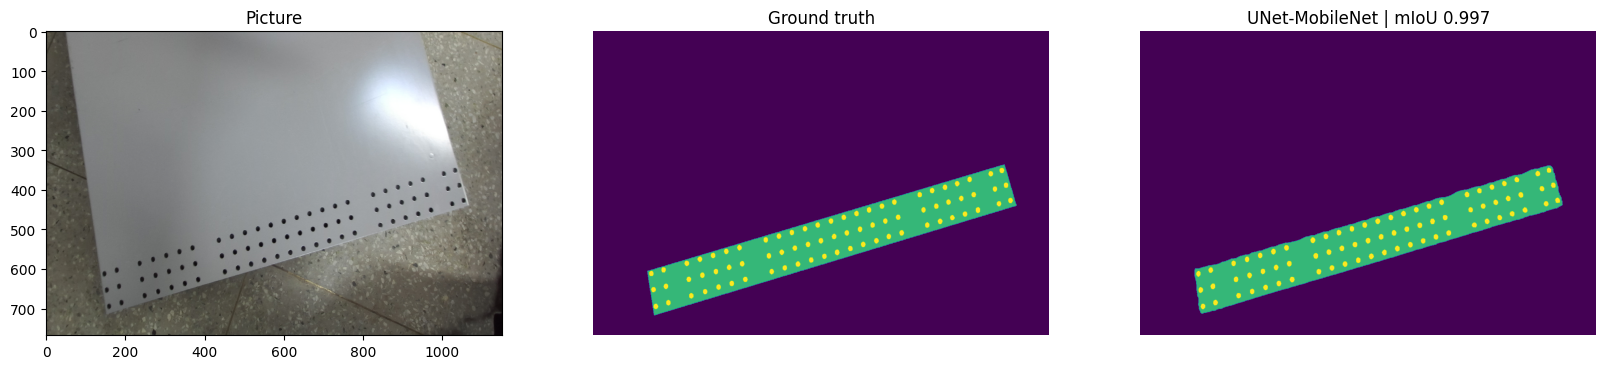

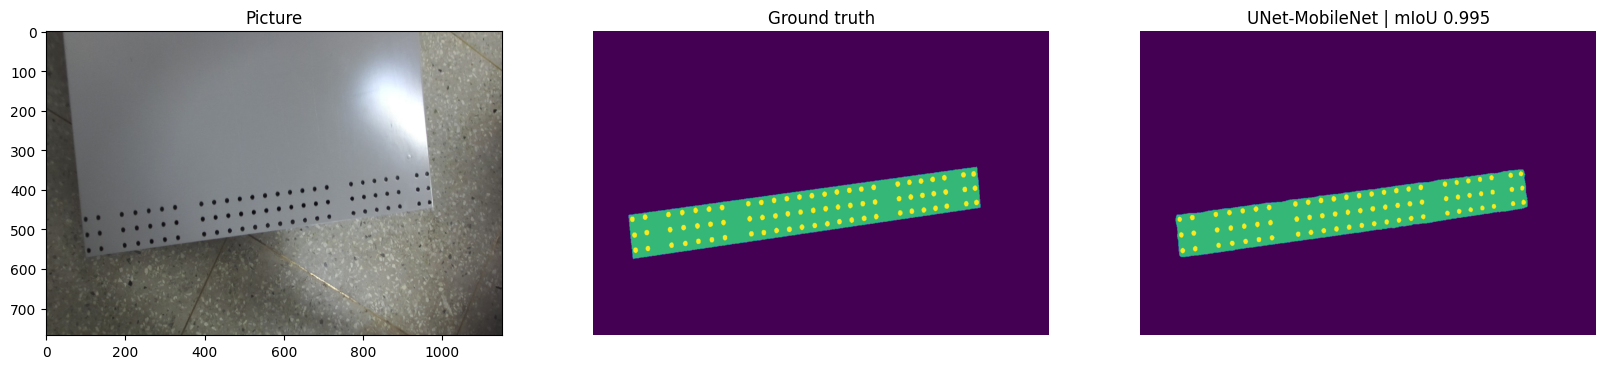

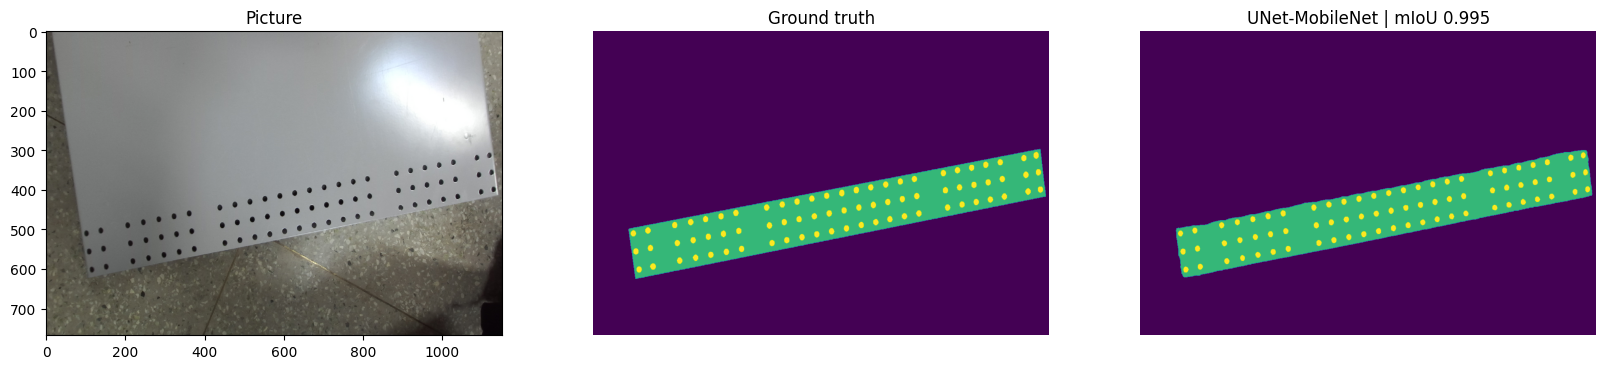

In [51]:
for test_img, test_mask in zip(test_imgs, test_masks):
    pred_mask, score = predict_image_mask_miou(model, test_img, test_mask)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(test_img)
    ax1.set_title('Picture')

    ax2.imshow(test_mask)
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(pred_mask)
    ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
    ax3.set_axis_off()